In [1]:
from dataclasses import dataclass
from functools import partial, reduce
import json
import math
import operator
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def fourie_term(n: int, xi: float, t: float) -> float:
    l = 0.5 * math.pi + math.pi * n
    return (
        4
        * (-1) ** n
        / (math.pi * (2 * n + 1))
        * math.exp(-(l**2) * t)
        * math.cos(l * xi)
    )


def fourie_series(N: int) -> float:
    def f(t: float, xi: float) -> float:
        term = lambda n: fourie_term(n, xi, t)
        return reduce(operator.add, map(term, range(N)))
    return f


def phi_2k(k: int, xi: float) -> float:
    return 1 - math.pow(xi, 2 * k)

def phi_4k(k: int, xi: float) -> float:
    return 1 - math.pow(xi, 4 * k)


In [3]:
@dataclass
class Solution:
    alpha: np.matrix
    lambda_: np.ndarray
    c: np.ndarray

    @classmethod
    def load(cls, f) -> "Solution":
        payload = json.load(f)
        return cls(
            alpha=np.array(payload["alpha"]),
            lambda_=np.array(payload["lambda"]),
            c=np.array(payload["c"]),
        )


In [4]:
def numeric_solution(phi_k: Callable[[int, float], float], params: Solution):
    def f(t: float, xi: float):
        N, _ = params.alpha.shape
        return reduce(
            operator.add,
            (
                params.c[i] * math.exp(-params.lambda_[i] * t) * params.alpha[j, i] * phi_k(j + 1, xi)
                for i in range(N)
                for j in range(N)
            ),
        )

    return f

In [5]:
with open("../data/2k_solution_5_order.json") as f:
    payload_5_order = Solution.load(f)
solution_5_order = numeric_solution(phi_2k, payload_5_order)

In [6]:
with open("../data/2k_solution_10_order.json") as f:
    payload_10_order = Solution.load(f)
solution_10_order = numeric_solution(phi_2k, payload_10_order)

In [7]:
exact_solution = fourie_series(10000)

In [8]:
times = (0.0, 0.1, 1.0, 10.0)

xi = np.linspace(0, 1, 1000)

In [73]:
data = []
for t in times:
    exact = np.array(list(map(lambda xi: exact_solution(t, xi), xi)))
    theta_5_order = np.array(list(map(lambda xi: solution_5_order(t, xi), xi)))
    theta_10_order = np.array(list(map(lambda xi: solution_10_order(t, xi), xi)))
    data.append((exact, theta_5_order, theta_10_order))

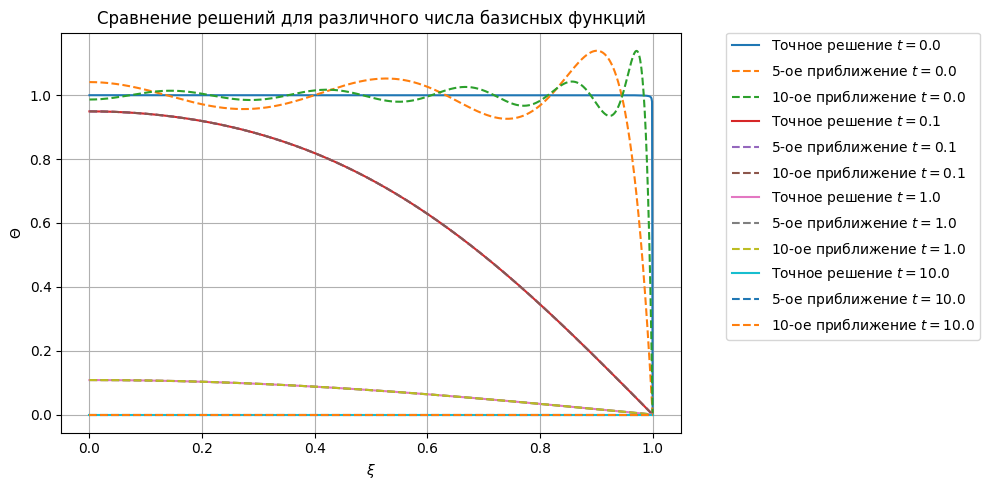

In [81]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios":[3, 1]})
ax.grid(True)
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$\\Theta$")
ax.set_title("Сравнение решений для различного числа базисных функций")

xi = np.linspace(0, 1, 1000)

for t, (exact, theta_5_order, theta_10_order) in zip(times, data):
    ax.plot(xi, exact, label=f"Точное решение $t={t}$")
    ax.plot(xi, theta_5_order, "--", label=f"5-ое приближение $t={t}$")
    ax.plot(xi, theta_10_order, "--", label=f"10-ое приближение $t={t}$")

h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.tight_layout()

In [82]:
fig.savefig("../images/2k_solutions_comparison.png")

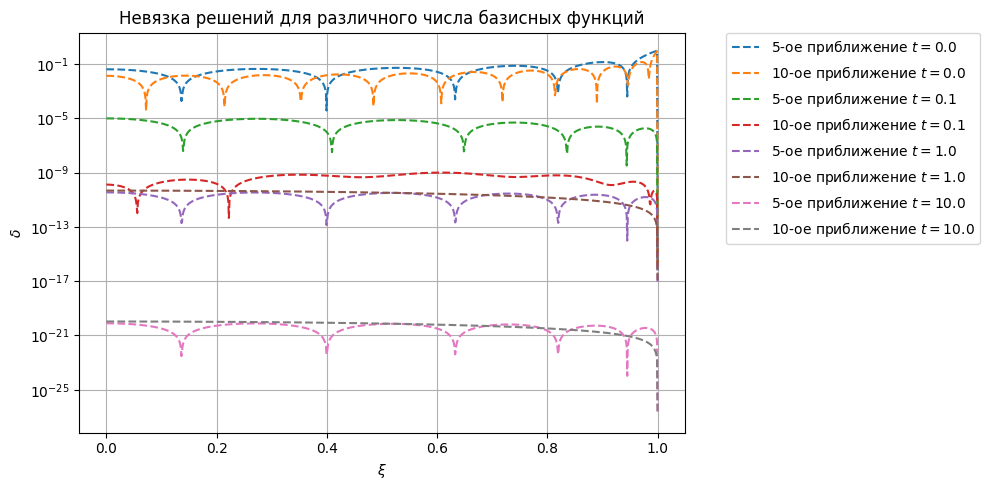

In [83]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios":[3, 1]})
ax.grid(True)
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$\\delta$")
ax.set_title("Невязка решений для различного числа базисных функций")
ax.set_yscale("log")

xi = np.linspace(0, 1, 1000)

for t, (exact, theta_5_order, theta_10_order) in zip(times, data):
    ax.plot(xi, abs(theta_5_order - exact), "--", label=f"5-ое приближение $t={t}$")
    ax.plot(xi, abs(theta_10_order - exact), "--", label=f"10-ое приближение $t={t}$")

h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.tight_layout()

In [84]:
fig.savefig("../images/2k_solutions_discrepancy.png")

In [9]:
def discrepancy(solution: Callable[[float, float], float]):
    def f(t: float, xi: float):
        return abs(exact_solution(t, xi) - solution(t, xi))
    return f

In [10]:
f_discrepancy_5_order_left = partial(discrepancy(solution_5_order), xi=0.1)
f_discrepancy_5_order_right = partial(discrepancy(solution_5_order), xi=1.0)

f_discrepancy_10_order_left = partial(discrepancy(solution_10_order), xi=0.1)
f_discrepancy_10_order_right = partial(discrepancy(solution_10_order), xi=1.0)

In [11]:
time = np.linspace(0, 10, 1000)

discrepancy_5_order_left = np.array(list(map(f_discrepancy_5_order_left, time)))
discrepancy_5_order_right = np.array(list(map(f_discrepancy_5_order_right, time)))

discrepancy_10_order_left = np.array(list(map(f_discrepancy_10_order_left, time)))
discrepancy_10_order_right = np.array(list(map(f_discrepancy_10_order_right, time)))

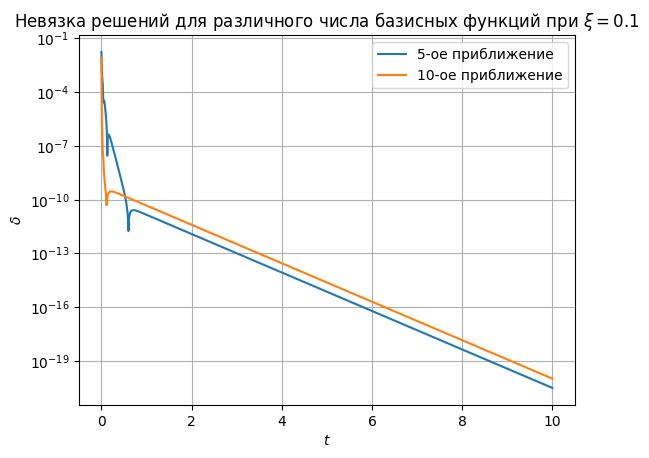

In [12]:
fig, ax = plt.subplots(1, 1)
ax.grid(True)
ax.set_xlabel("$t$")
ax.set_ylabel("$\\delta$")
ax.set_title("Невязка решений для различного числа базисных функций при $\\xi = 0.1$")
ax.set_yscale("log")

ax.plot(time, discrepancy_5_order_left, label="5-ое приближение")
ax.plot(time, discrepancy_10_order_left, label="10-ое приближение")

ax.legend()

In [13]:
fig.savefig("../images/discrepancy_xi_left.png")

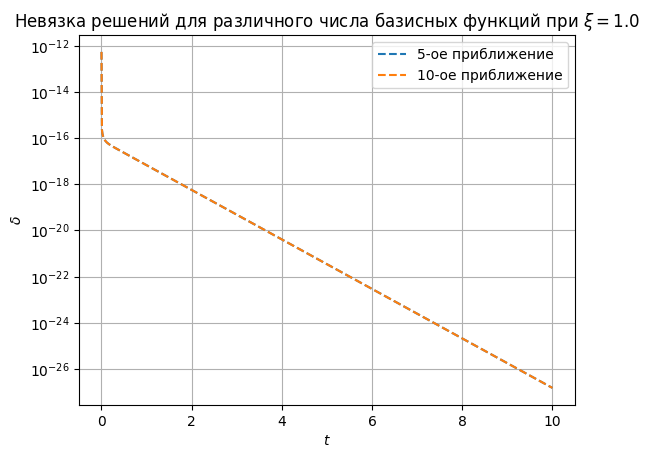

In [14]:
fig, ax = plt.subplots(1, 1)
ax.grid(True)
ax.set_xlabel("$t$")
ax.set_ylabel("$\\delta$")
ax.set_title("Невязка решений для различного числа базисных функций при $\\xi = 1.0$")
ax.set_yscale("log")

ax.plot(time, discrepancy_5_order_right, "--", label="5-ое приближение")
ax.plot(time, discrepancy_10_order_right, "--", label="10-ое приближение")

ax.legend()

In [15]:
fig.savefig("../images/discrepancy_xi_right.png")

In [111]:
t = np.linspace(0, 10, 100)

f_avg_temp_exact = lambda t: np.average(np.array(list(map(lambda xi: exact_solution(t, xi), xi))))
avg_temp_exact = np.array(list(map(f_avg_temp_exact, t)))

f_avg_temp_5_order = lambda t: np.average(np.array(list(map(lambda xi: solution_5_order(t, xi), xi))))
avg_temp_5_order = np.array(list(map(f_avg_temp_5_order, t)))

f_avg_temp_10_order = lambda t: np.average(np.array(list(map(lambda xi: solution_10_order(t, xi), xi))))
avg_temp_10_order = np.array(list(map(f_avg_temp_10_order, t)))

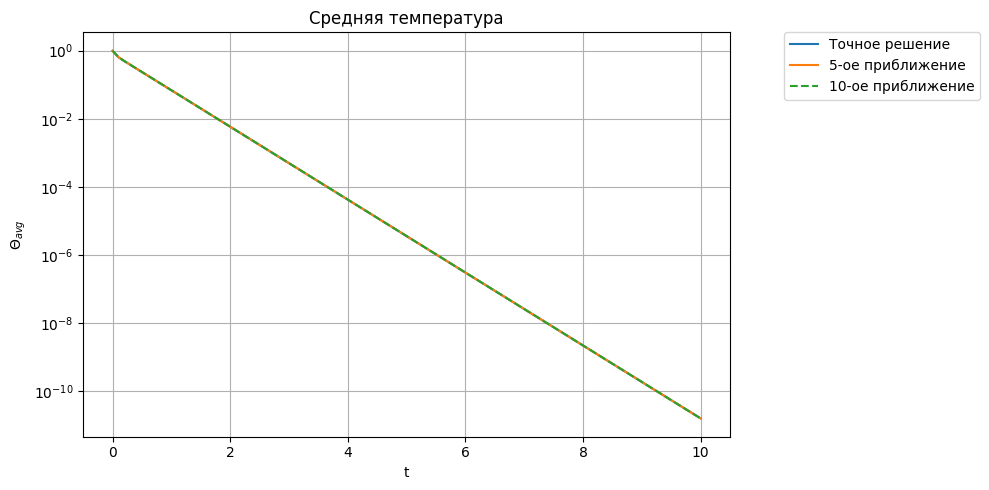

In [114]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios":[3, 1]})
ax.grid(True)

ax.set_xlabel("t")
ax.set_ylabel("$\\Theta_{avg}$")
ax.set_yscale("log")
ax.set_title("Средняя температура")

ax.plot(t, avg_temp_exact, label="Точное решение")
ax.plot(t, avg_temp_5_order, label="5-ое приближение")
ax.plot(t, avg_temp_10_order, "--", label="10-ое приближение")

h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.tight_layout()

In [115]:
fig.savefig("../images/average_temp.png")

In [116]:
with open("../data/4k_solution_5_order.json") as f:
    payload_5_order_4k = Solution.load(f)
solution_5_order_4k = numeric_solution(phi_4k, payload_5_order_4k)

In [117]:
times = (0.0, 0.1, 1.0, 10.0)

data = []
for t in times:
    exact = np.array(list(map(lambda xi: exact_solution(t, xi), xi)))
    theta_5_order_2k = np.array(list(map(lambda xi: solution_5_order(t, xi), xi)))
    theta_5_order_4k = np.array(list(map(lambda xi: solution_5_order_4k(t, xi), xi)))
    data.append((exact, theta_5_order_2k, theta_5_order_4k))

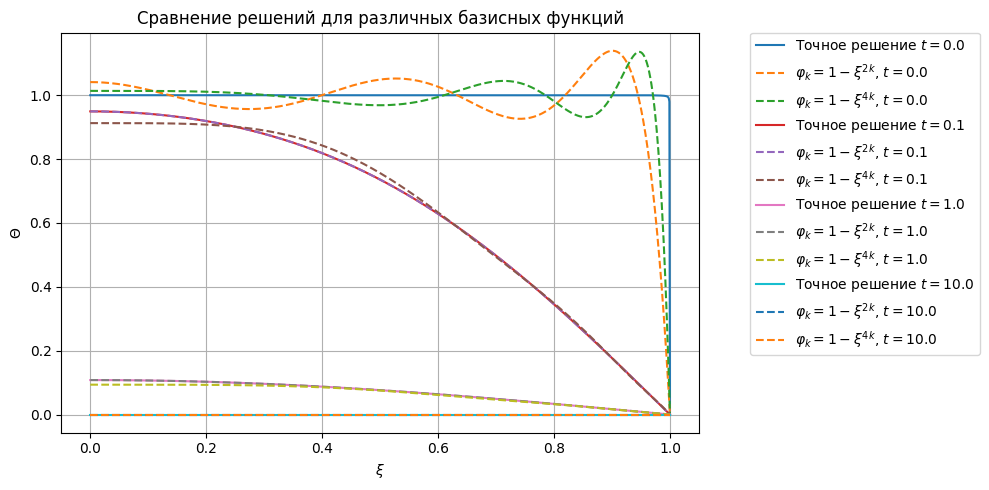

In [122]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios":[3, 1]})
ax.grid(True)
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$\\Theta$")
ax.set_title("Сравнение решений для различных базисных функций")

xi = np.linspace(0, 1, 1000)

for t, (exact, theta_5_order_2k, theta_5_order_4k) in zip(times, data):
    ax.plot(xi, exact, label=f"Точное решение $t={t}$")
    ax.plot(xi, theta_5_order_2k, "--", label="$\\varphi_k=1 - \\xi^{2k}$, " f"$t={t}$")
    ax.plot(xi, theta_5_order_4k, "--", label="$\\varphi_k=1 - \\xi^{4k}$, " f"$t={t}$")

h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.tight_layout()

In [123]:
fig.savefig("../images/solutions_2k_4k_comparison.png")

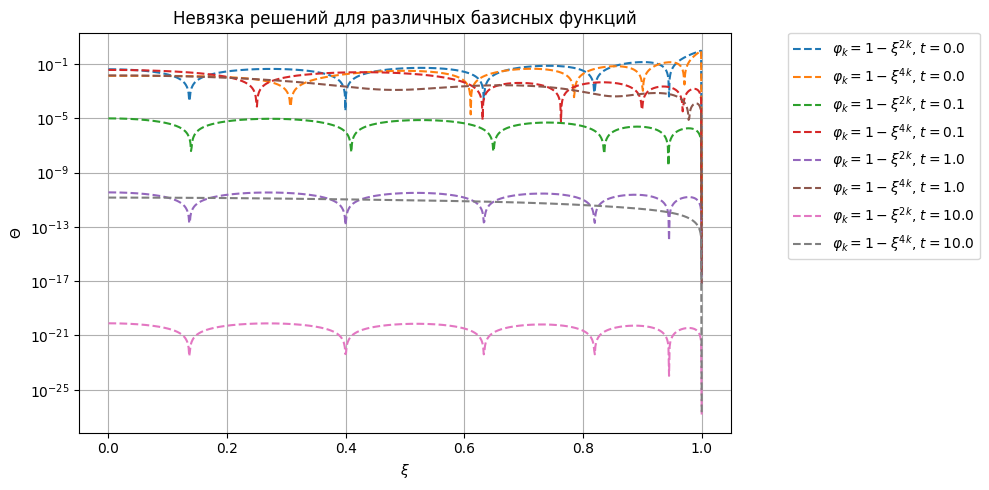

In [125]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios":[3, 1]})
ax.grid(True)
ax.set_xlabel("$\\xi$")
ax.set_ylabel("$\\Theta$")
ax.set_title("Невязка решений для различных базисных функций")
ax.set_yscale("log")

xi = np.linspace(0, 1, 1000)

for t, (exact, theta_5_order_2k, theta_5_order_4k) in zip(times, data):
    ax.plot(xi, abs(theta_5_order_2k - exact), "--", label="$\\varphi_k=1 - \\xi^{2k}$, " f"$t={t}$")
    ax.plot(xi, abs(theta_5_order_4k - exact), "--", label="$\\varphi_k=1 - \\xi^{4k}$, " f"$t={t}$")

h, l = ax.get_legend_handles_labels()
lax.legend(h, l, borderaxespad=0)
lax.axis("off")
fig.tight_layout()

In [126]:
fig.savefig("../images/solutions_2k_4k_discrepancy.png")